In [1]:
import numpy as np
import sklearn
import skimage
import skimage.transform
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.segmentation
import copy
from sklearn.linear_model import LinearRegression
import cv2 as cv2
import matplotlib.pyplot as plt
import random
from lime import lime_image

In [2]:
img = skimage.data.chelsea()
img = skimage.transform.resize(img, (299,299)) 

In [3]:
np.random.seed()
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model
preds = inceptionV3_model.predict(img[np.newaxis])
top_pred_classes = preds[0].argsort()[-7:][::-1] # Save ids of top 5 classes
decode_predictions(preds)[0] #Print top 5 classes

[('n02124075', 'Egyptian_cat', 0.8812201),
 ('n02123045', 'tabby', 0.06866199),
 ('n02123159', 'tiger_cat', 0.040356144),
 ('n02127052', 'lynx', 0.0002648961),
 ('n03958227', 'plastic_bag', 0.00011896533)]

In [4]:
for x in preds.argsort()[-1][-5:]:
    print (x, preds[0,x])

728 0.00011896533
287 0.0002648961
282 0.040356144
281 0.06866199
285 0.8812201


In [5]:
def segmentation(img):
    return skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2) #4 200 0.2

In [6]:
explainer = lime_image.LimeImageExplainer()

In [7]:
explanation = explainer.explain_instance(img, inceptionV3_model.predict, top_labels=5, hide_color=0, num_samples=1000, segmentation_fn = segmentation)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
#explanation.local_exp[285]

In [9]:
num_superpixels = len(explanation.local_exp[285])
superpixels = segmentation(img)

In [10]:
num_superpixels

57

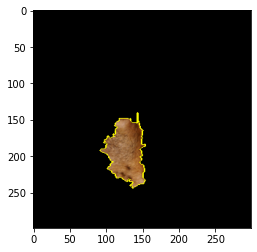

In [11]:
temp, mask = explanation.get_image_and_mask(285, positive_only=True, num_features=1, hide_rest=True)
plt.imshow(skimage.segmentation.mark_boundaries(temp, mask))

In [12]:
perturbations = []
for i in explanation.local_exp[285]:
    temp = np.zeros(num_superpixels)
    temp[i[0]] = 1
    perturbations.append(temp)

In [13]:
def perturb_image(img,perturbation,segments):
    average = img.mean(axis=0).mean(axis=0)
    active_pixels = np.where(perturbation == 0)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    perturbed_image[(mask == 0)] = average
    return perturbed_image

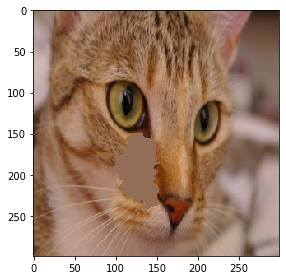

In [14]:
skimage.io.imshow(perturb_image(img, perturbations[0], superpixels))

In [15]:
predictions = []
for i in explanation.local_exp[285]:
    perturbed_img = perturb_image(img,perturbations[0], superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis, :, :, :])
    predictions.append(pred)

In [16]:
predictions = np.array(predictions)
print(predictions.shape)

(57, 1, 1000)


In [17]:
#Compute distances to original image
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

(57,)


In [18]:
#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(57,)


In [19]:
simpler_model = LinearRegression()

In [20]:
simpler_model.fit(X=perturbations, y=predictions[:, :, 0], sample_weight=weights)

LinearRegression()

In [21]:
from sklearn.compose import ColumnTransformer
import sys
sys.path.append("..")
from inxai import *
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import preprocessing

In [22]:
X_train, X_test, y_train, y_test = train_test_split(perturbations, predictions[:, :, 0], test_size=0.2, random_state=42)

In [29]:
gm = GlobalFeatureMetric()

In [30]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=10),X_test)])

In [32]:
acc_loss = gm.gradual_perturbation(model=simpler_model, X=perturbations, y=predictions[:, :, 0], resolution=50,  count_per_step=10, column_transformer = ct, importances_orig = perm_importances)

ValueError: continuous is not supported